# Assignment3 - Question 1  (Alejandro Akifarry - 301-195-788)
---

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import mode

---

## 1. Retrieve and load the Olivetti faces dataset

In [2]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


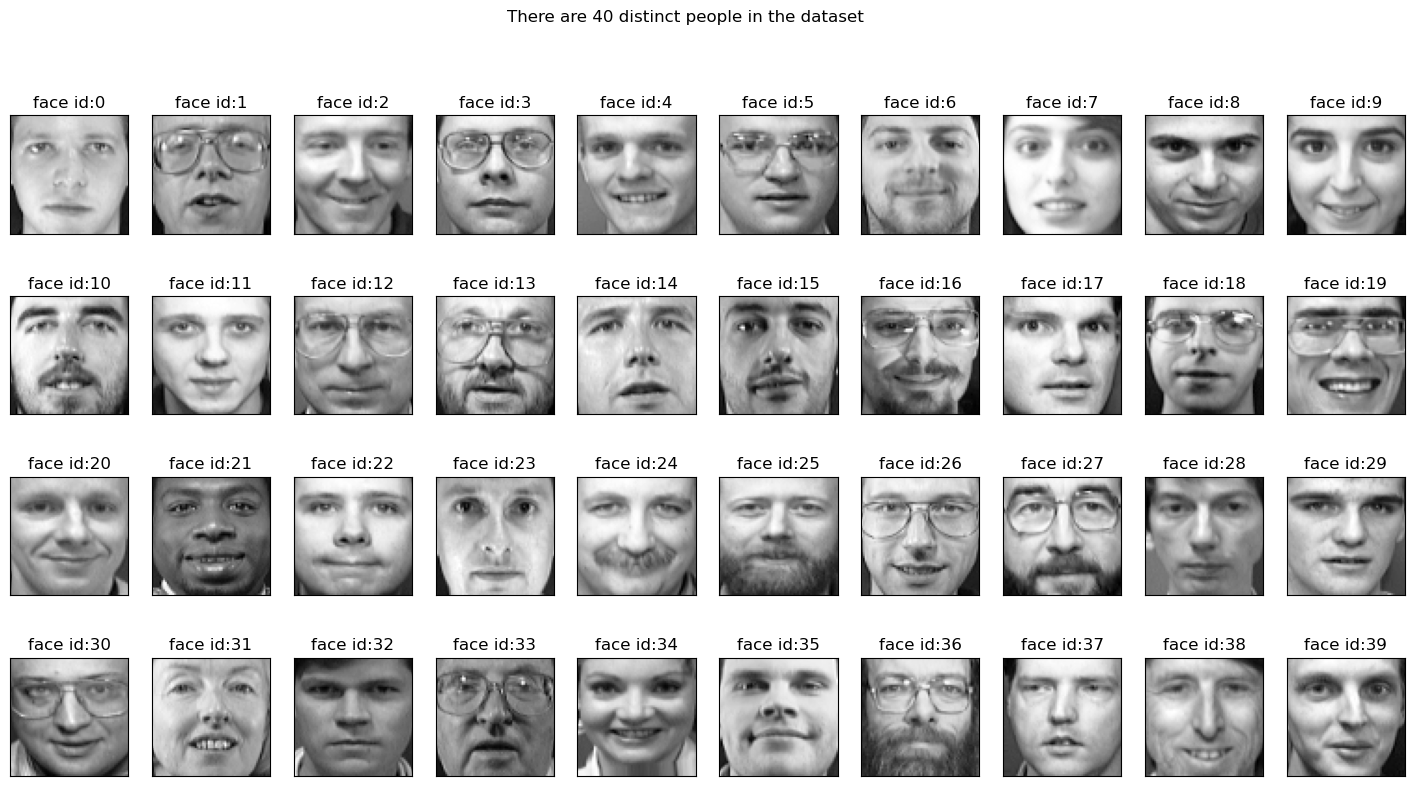

In [3]:
# From Reference [1]
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

show_40_distinct_people(images, np.unique(y))

---

## 2. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.

In [4]:
'''
Split is:
80% train
10% validation
10% test
to ensure we have a lot of data to train, 
and also still have some left for validation and testing
'''
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)


---

## 3. Using k-fold cross validation, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.

In [6]:
# Use SVC with linear kernel
clf = SVC(kernel='linear', random_state=42)

# Instantiate StratifiedKFold
# use n_splits=4 so the 8 training samples per class can be evenly distributed
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Run k-fold CV
cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')

# Print scores
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

# Train the classifier on the entire training set
clf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation set accuracy: {val_accuracy:.4f}")

Cross-validation accuracy scores: [0.95   0.9875 0.9875 0.9375]
Mean cross-validation accuracy: 0.9656
Validation set accuracy: 0.9750


---

## 4. Using either Agglomerative Hierarchical Clustering (AHC) or Divisive Hierarchical Clustering (DHC) and using the centroid-based clustering rule, reduce the dimensionality of the set by using the following similarity measures:

In [7]:
n_clusters = 40

In [8]:
# From Reference [2]
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    title = kwargs.pop('title', "")
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        # plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.title(title)
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Function to simplify code to use fancy_dendrogram()
def use_fancy_dendrogram(Z, title, filename):
  plt.figure(figsize=(25, 10))
  fancy_dendrogram(Z,
                 leaf_rotation=90,
                 leaf_font_size=12,
                 show_contracted=True,
                 title=title
                )
  plt.savefig(filename)
  plt.show()

In [9]:
def get_centroids(X, labels):
  unique_labels = np.unique(labels)
  centroids_list = []
  for i in unique_labels:
    # Take points that belong to cluster i
    cluster_points = X[labels == i]

    # Calculate the mean points of the points in the cluster
    centroid = cluster_points.mean(axis=0)

    # Add to list
    centroids_list.append(centroid)
  centroids = np.array(centroids_list)
  return centroids

### a) Euclidean Distance

In [10]:
# Use euclidean distance
dist_euclidean = pdist(X, metric="euclidean")

# Perform agglomerative clustering
Z_euclidean = linkage(dist_euclidean, method="centroid")

# Get labels (which cluster each point belongs to)
labels_euclidean = fcluster(Z_euclidean, t=n_clusters, criterion="maxclust")

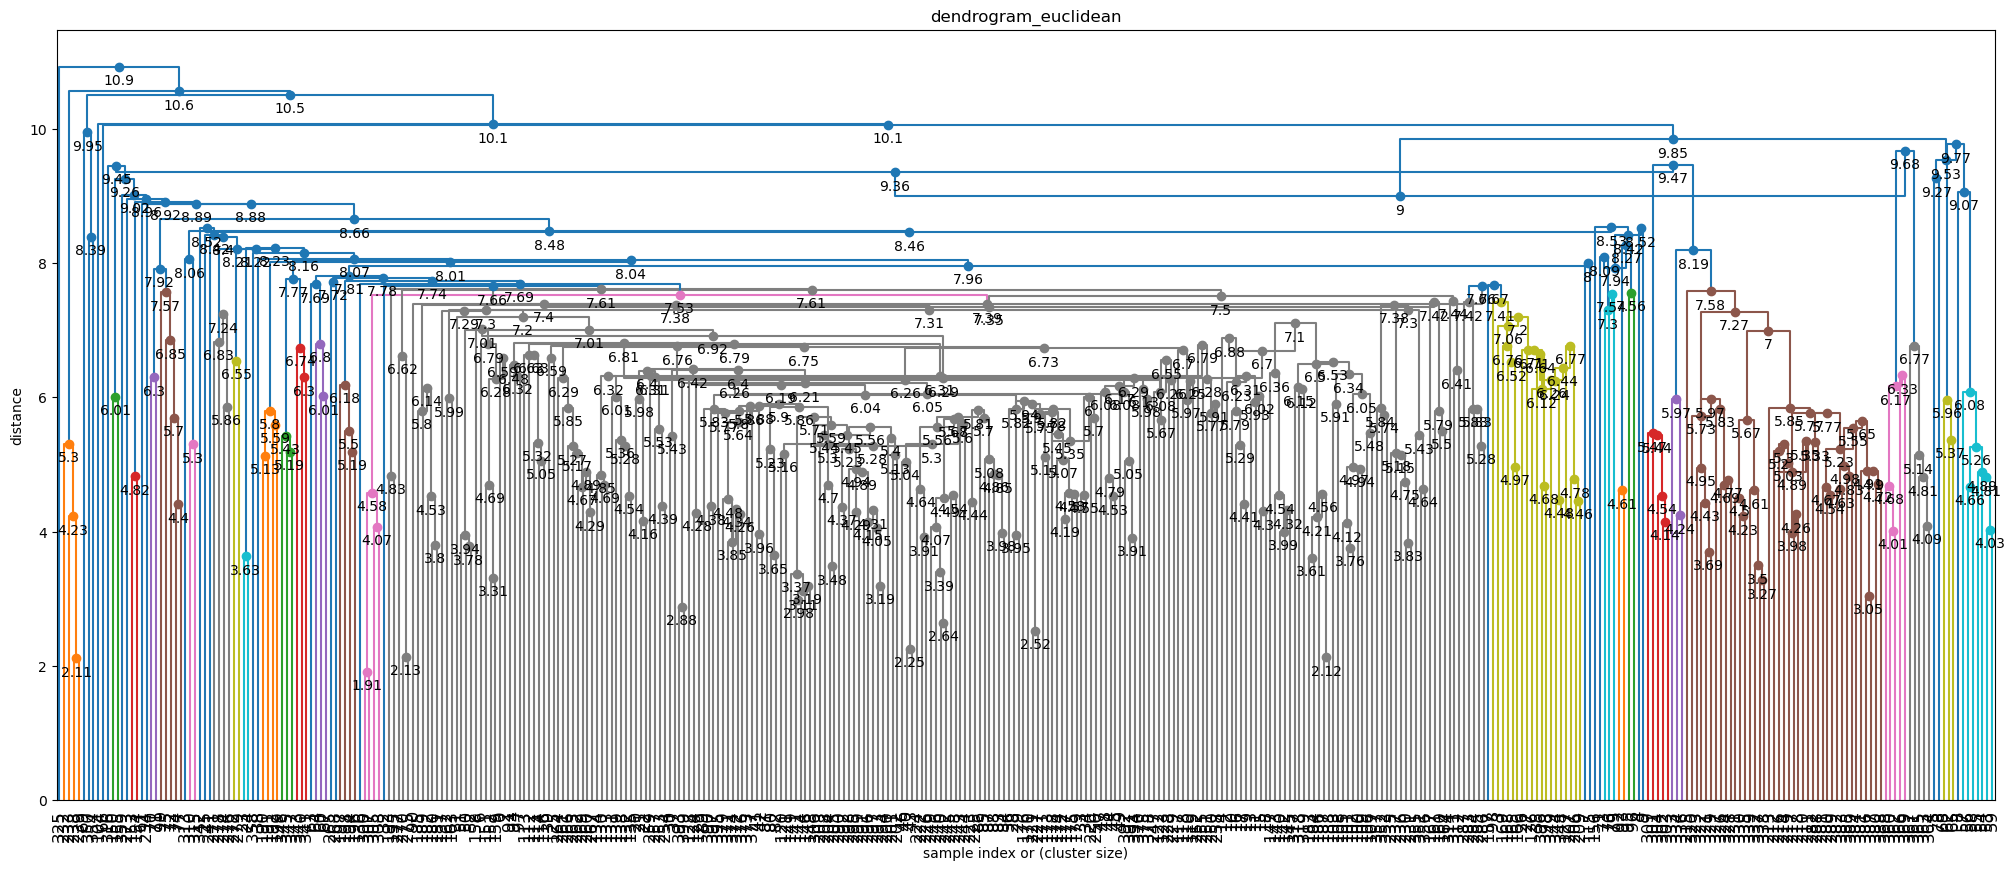

In [11]:
# Show how data points are merged
use_fancy_dendrogram(Z_euclidean, f"dendrogram_euclidean", f"dendrogram_euclidean.png")

In [12]:
# Get reduced dataset
X_reduced_euclidean = get_centroids(X, labels_euclidean)
X_reduced_euclidean.shape

(40, 4096)

### b) Minkowski Distance

In [13]:
# Use minkowski distance (if p=2, equivalent to Euclidean)
# p=1 is Manhattan
dist_minkowski = pdist(X, metric="minkowski", p=1)

# Perform agglomerative clustering
Z_minkowski = linkage(dist_minkowski, method="centroid")

# Get labels (which cluster each point belongs to)
labels_minkowski = fcluster(Z_minkowski, t=n_clusters, criterion="maxclust")

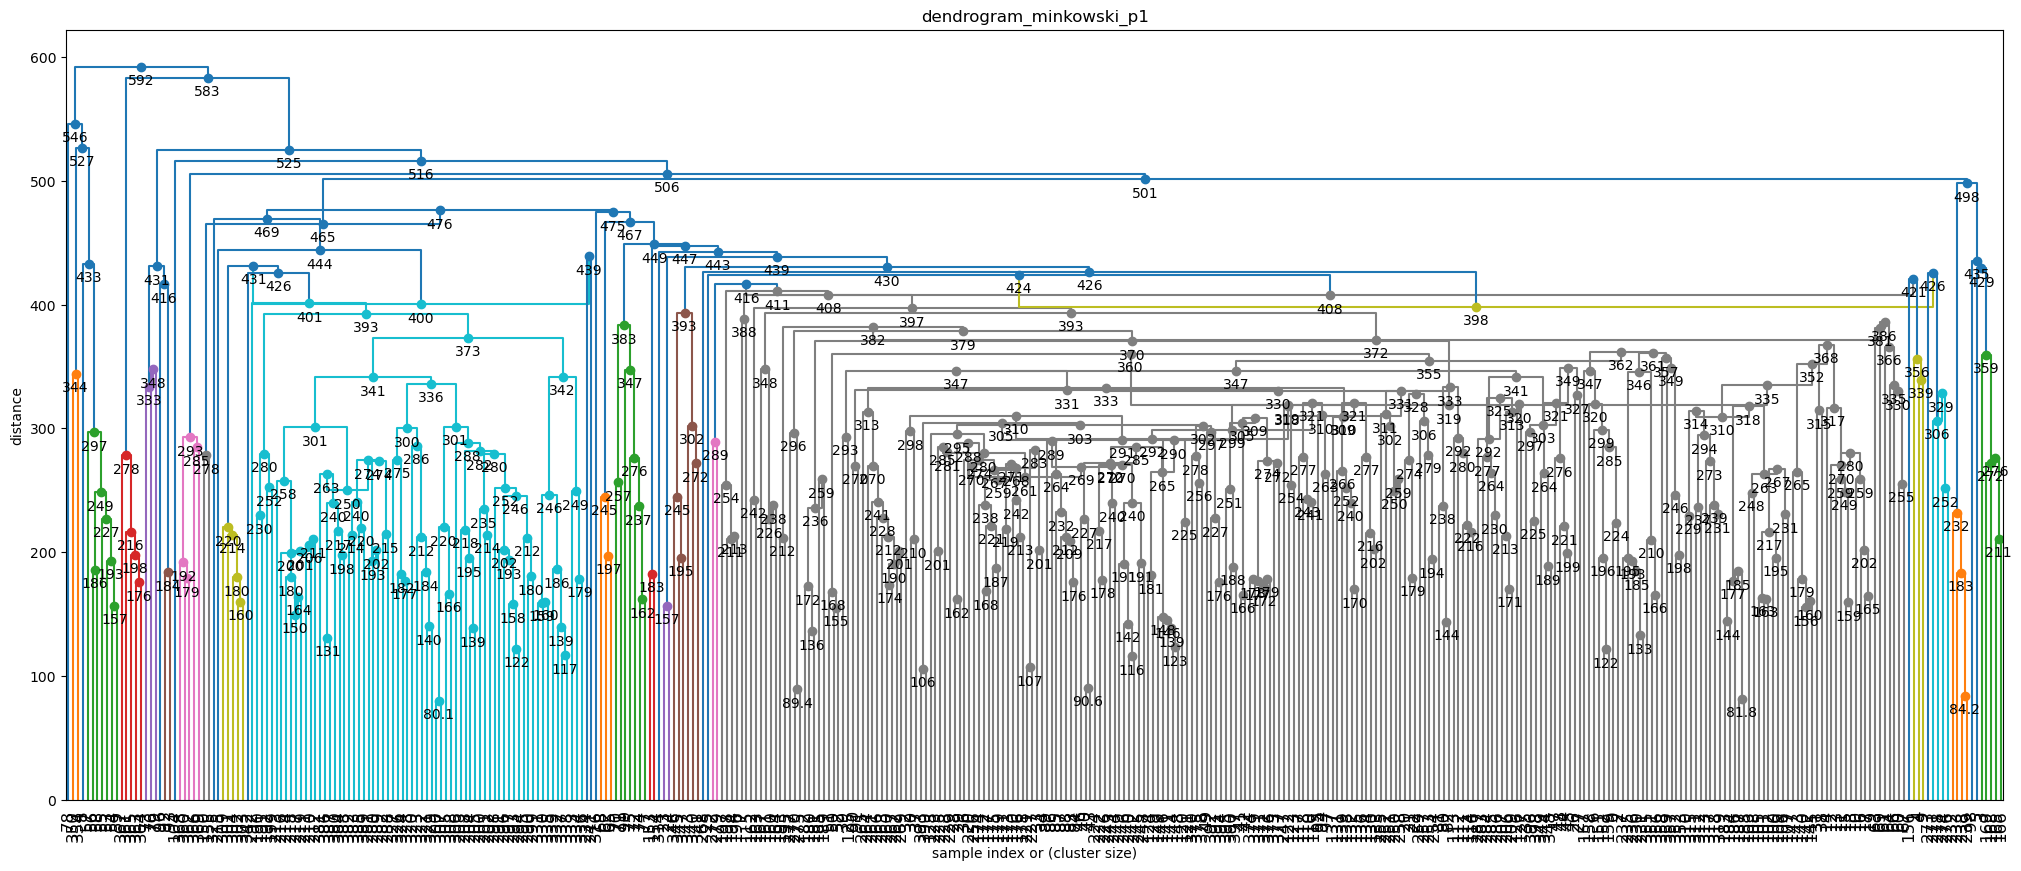

In [14]:
# Show how data points are merged
use_fancy_dendrogram(Z_minkowski, f"dendrogram_minkowski_p1", f"dendrogram_minkowski_p1.png")

In [15]:
# Get reduced dataset
X_reduced_minkowski = get_centroids(X, labels_minkowski)
X_reduced_minkowski.shape

(40, 4096)

### c) Cosine Similarity

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used. If y is passed as precomputed pairwise distances, then it is the user’s responsibility to assure that these distances are in fact Euclidean, otherwise the produced result will be incorrect.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [16]:
# Use cosine similarity
dist_cosine = pdist(X, metric="cosine")

# Perform agglomerative clustering
Z_cosine = linkage(dist_cosine, method="average")

# Get labels (which cluster each point belongs to)
labels_cosine = fcluster(Z_cosine, t=n_clusters, criterion="maxclust")

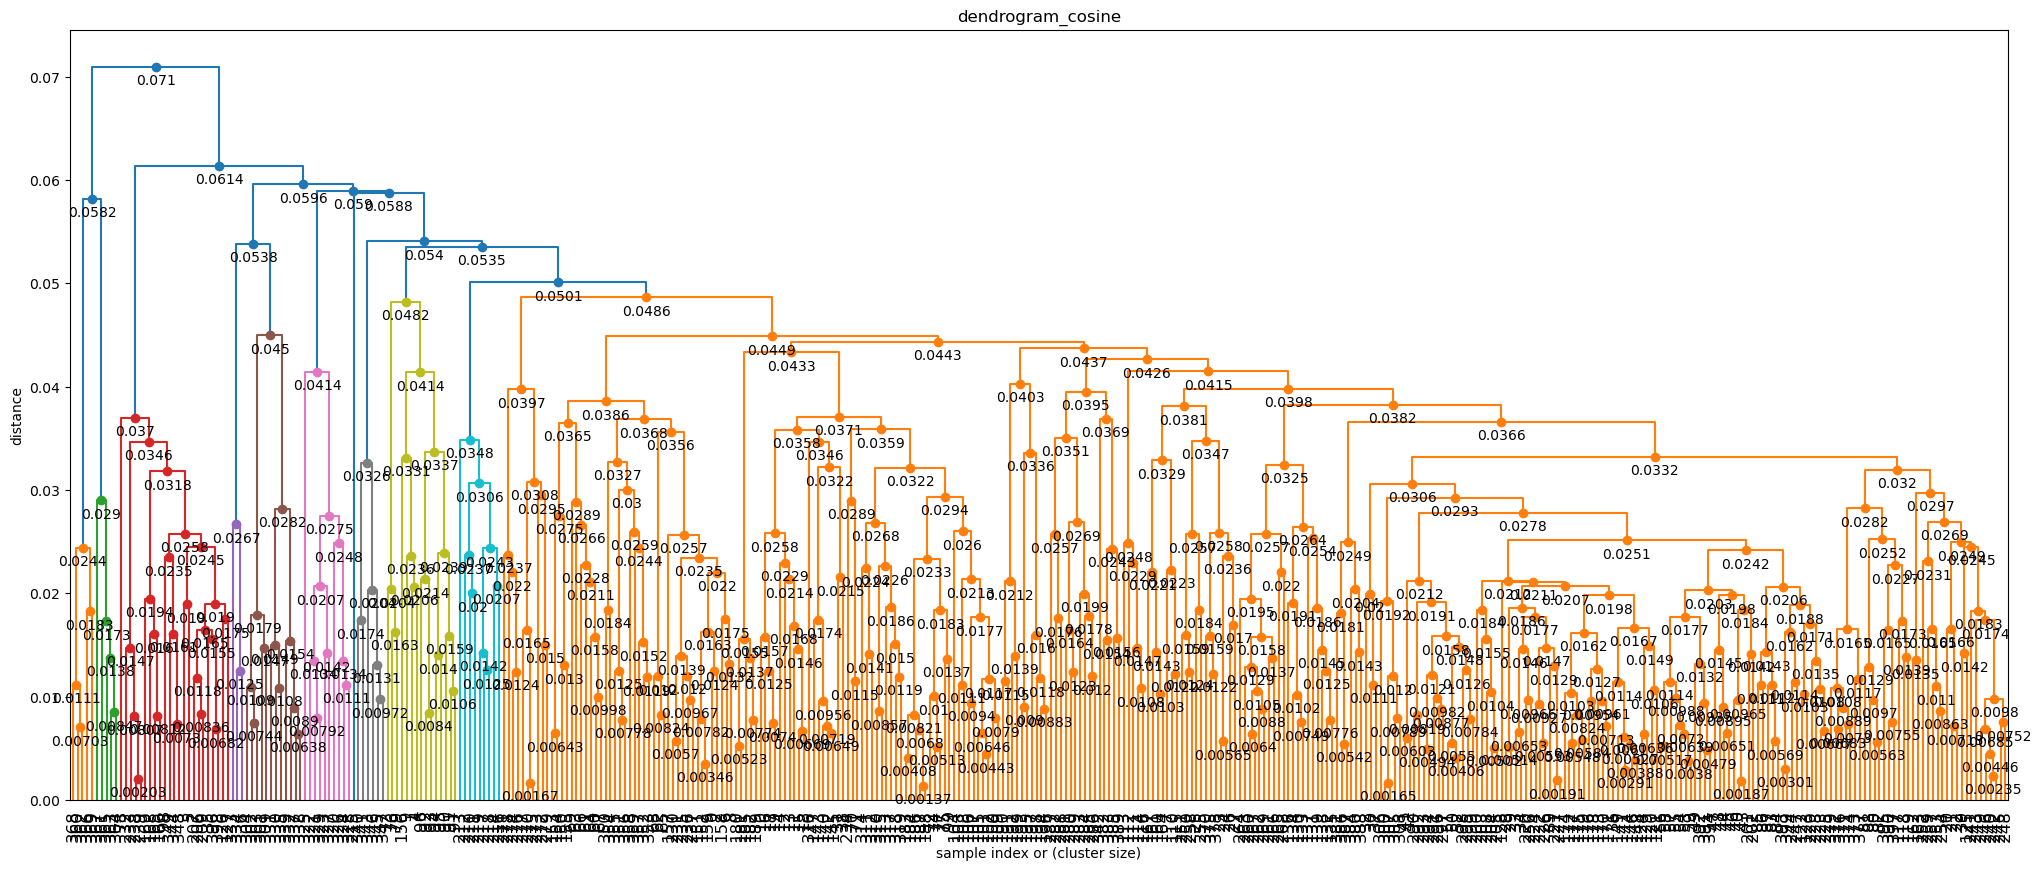

In [17]:
# Show how data points are merged
use_fancy_dendrogram(Z_cosine, f"dendrogram_cosine", f"dendrogram_cosine.png")

In [18]:
# Get reduced dataset
X_reduced_cosine = get_centroids(X, labels_cosine)
X_reduced_cosine.shape

(40, 4096)

---

## 5. Discuss any discrepancies observed between 4(a), 4(b), or 4(c). Use the silhouette score approach to choose the number of clusters for 4(a), 4(b), and 4(c).

In [19]:
cluster_range = range(20, 150)
silhouette_scores = {
    "euclidean": [],
    "minkowski": [],
    "cosine": []
}

for c in cluster_range:
  print(f"c: {c}")
  labels_euclidean = fcluster(Z_euclidean, t=c, criterion="maxclust")
  labels_minkowski = fcluster(Z_minkowski, t=c, criterion="maxclust")
  labels_cosine = fcluster(Z_cosine, t=c, criterion="maxclust")

  sil_euclidean = silhouette_score(X, labels_euclidean, metric='euclidean')
  sil_minkowski = silhouette_score(X, labels_minkowski, metric='minkowski', p=1)
  sil_cosine = silhouette_score(X, labels_cosine, metric='cosine')

  silhouette_scores["euclidean"].append(sil_euclidean)
  silhouette_scores["minkowski"].append(sil_minkowski)
  silhouette_scores["cosine"].append(sil_cosine)

optimal_euclidean = cluster_range[np.argmax(silhouette_scores["euclidean"])]
optimal_minkowski = cluster_range[np.argmax(silhouette_scores["minkowski"])]
optimal_cosine = cluster_range[np.argmax(silhouette_scores["cosine"])]

print(f"Optimal number of clusters for euclidean: {optimal_euclidean}")
print(f"Optimal number of clusters for minkowski (p=1): {optimal_minkowski}")
print(f"Optimal number of clusters for cosine: {optimal_cosine}")

c: 20
c: 21
c: 22
c: 23
c: 24
c: 25
c: 26
c: 27
c: 28
c: 29
c: 30
c: 31
c: 32
c: 33
c: 34
c: 35
c: 36
c: 37
c: 38
c: 39
c: 40
c: 41
c: 42
c: 43
c: 44
c: 45
c: 46
c: 47
c: 48
c: 49
c: 50
c: 51
c: 52
c: 53
c: 54
c: 55
c: 56
c: 57
c: 58
c: 59
c: 60
c: 61
c: 62
c: 63
c: 64
c: 65
c: 66
c: 67
c: 68
c: 69
c: 70
c: 71
c: 72
c: 73
c: 74
c: 75
c: 76
c: 77
c: 78
c: 79
c: 80
c: 81
c: 82
c: 83
c: 84
c: 85
c: 86
c: 87
c: 88
c: 89
c: 90
c: 91
c: 92
c: 93
c: 94
c: 95
c: 96
c: 97
c: 98
c: 99
c: 100
c: 101
c: 102
c: 103
c: 104
c: 105
c: 106
c: 107
c: 108
c: 109
c: 110
c: 111
c: 112
c: 113
c: 114
c: 115
c: 116
c: 117
c: 118
c: 119
c: 120
c: 121
c: 122
c: 123
c: 124
c: 125
c: 126
c: 127
c: 128
c: 129
c: 130
c: 131
c: 132
c: 133
c: 134
c: 135
c: 136
c: 137
c: 138
c: 139
c: 140
c: 141
c: 142
c: 143
c: 144
c: 145
c: 146
c: 147
c: 148
c: 149
Optimal number of clusters for euclidean: 142
Optimal number of clusters for minkowski (p=1): 146
Optimal number of clusters for cosine: 143


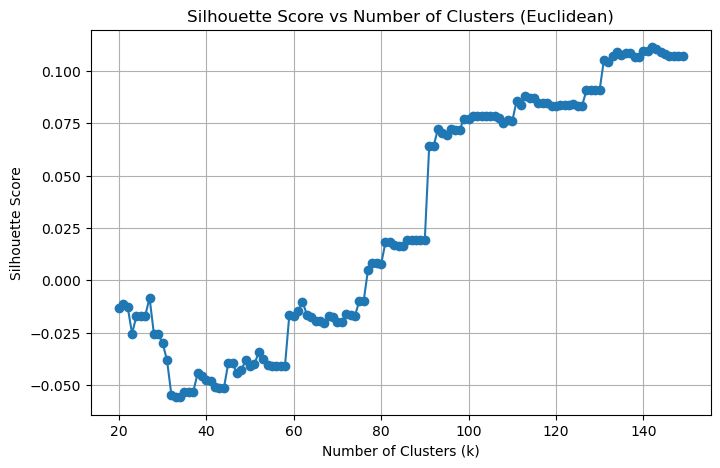

In [20]:
# Plot silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores["euclidean"], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (Euclidean)')
plt.grid(True)
plt.savefig("silhouette_euclidean.png")
plt.show()

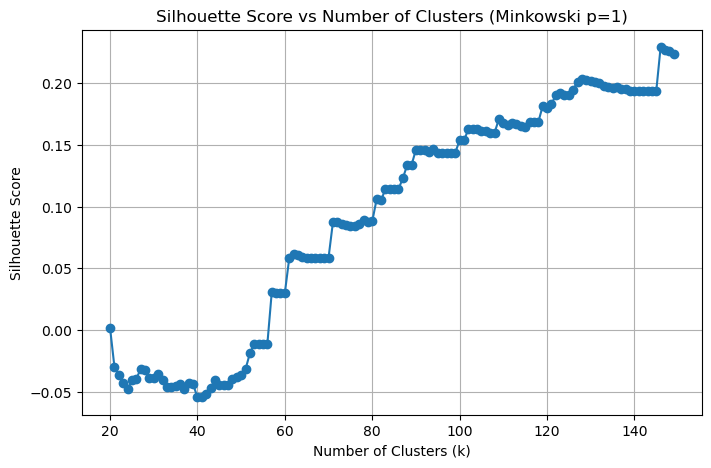

In [21]:
# Plot silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores["minkowski"], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (Minkowski p=1)')
plt.grid(True)
plt.savefig("silhouette_minkowski_p1.png")
plt.show()

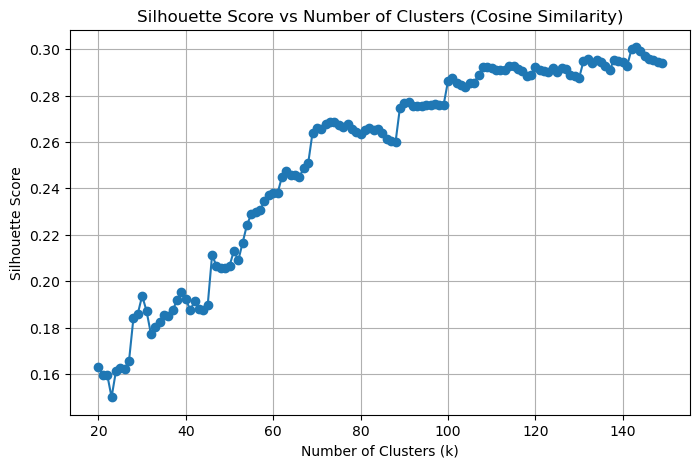

In [22]:
# Plot silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores["cosine"], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (Cosine Similarity)')
plt.grid(True)
plt.savefig("silhouette_cosine.png")
plt.show()

---

## 6. Use the set from (4(a), 4(b), or 4(c)) to train a classifier as in (3) using k-fold cross validation.

In [23]:
print(f"Optimal number of clusters for euclidean: {optimal_euclidean}")
print(f"Optimal number of clusters for minkowski: {optimal_minkowski}")
print(f"Optimal number of clusters for cosine: {optimal_cosine}")

Optimal number of clusters for euclidean: 142
Optimal number of clusters for minkowski: 146
Optimal number of clusters for cosine: 143


In [24]:
# Use euclidean distance
dist_euclidean = pdist(X, metric="euclidean")

# Perform agglomerative clustering
Z_euclidean = linkage(dist_euclidean, method="centroid")

# Get labels (which cluster each point belongs to)
labels_euclidean = fcluster(Z_euclidean, t=optimal_euclidean, criterion="maxclust")

In [25]:
# Use minkowski distance (if p=2, equivalent to Euclidean)
# p=1 is Manhattan
dist_minkowski = pdist(X, metric="minkowski", p=1)

# Perform agglomerative clustering
Z_minkowski = linkage(dist_minkowski, method="centroid")

# Get labels (which cluster each point belongs to)
labels_minkowski = fcluster(Z_minkowski, t=optimal_minkowski, criterion="maxclust")

In [26]:
# Use cosine similarity
dist_cosine = pdist(X, metric="cosine")

# Perform agglomerative clustering
Z_cosine = linkage(dist_cosine, method="average")

# Get labels (which cluster each point belongs to)
labels_cosine = fcluster(Z_cosine, t=optimal_cosine, criterion="maxclust")

In [27]:
def get_y_reduced(y, labels):
  y_reduced = []
  for i in np.unique(labels):
    cluster_indices = np.where(labels == i)

    cluster_labels = y[cluster_indices]

    cluster_label = mode(cluster_labels).mode

    y_reduced.append(cluster_label)
  return np.array(y_reduced)

In [28]:
# Get reduced Xs
X_reduced_euclidean = get_centroids(X, labels_euclidean)
X_reduced_minkowski = get_centroids(X, labels_minkowski)
X_reduced_cosine = get_centroids(X, labels_cosine)

# Get reduced ys
y_reduced_euclidean = get_y_reduced(y, labels_euclidean)
y_reduced_minkowski = get_y_reduced(y, labels_minkowski)
y_reduced_cosine = get_y_reduced(y, labels_cosine)

# Verify shapes
print(X_reduced_euclidean.shape)
print(y_reduced_euclidean.shape)
print(X_reduced_minkowski.shape)
print(y_reduced_minkowski.shape)
print(X_reduced_cosine.shape)
print(y_reduced_cosine.shape)

(142, 4096)
(142,)
(146, 4096)
(146,)
(143, 4096)
(143,)


In [29]:
# do train val test split like previously
# For Euclidean
X_train_val_euclidean, X_test_euclidean, y_train_val_euclidean, y_test_euclidean = train_test_split(
    X_reduced_euclidean, y_reduced_euclidean, test_size=0.1, random_state=42)

X_train_euclidean, X_val_euclidean, y_train_euclidean, y_val_euclidean = train_test_split(
    X_train_val_euclidean, y_train_val_euclidean, test_size=0.1111, random_state=42)

# For Minkowski
X_train_val_minkowski, X_test_minkowski, y_train_val_minkowski, y_test_minkowski = train_test_split(
    X_reduced_minkowski, y_reduced_minkowski, test_size=0.1, random_state=42)

X_train_minkowski, X_val_minkowski, y_train_minkowski, y_val_minkowski = train_test_split(
    X_train_val_minkowski, y_train_val_minkowski, test_size=0.1111, random_state=42)

# For Cosine Similarity
X_train_val_cosine, X_test_cosine, y_train_val_cosine, y_test_cosine = train_test_split(
    X_reduced_cosine, y_reduced_cosine, test_size=0.1, random_state=42)

X_train_cosine, X_val_cosine, y_train_cosine, y_val_cosine = train_test_split(
    X_train_val_cosine, y_train_val_cosine, test_size=0.1111, random_state=42)

In [30]:
print("Euclidean Shapes:")
print("X_train_euclidean:", X_train_euclidean.shape)
print("y_train_euclidean:", y_train_euclidean.shape)
print("X_val_euclidean:", X_val_euclidean.shape)
print("y_val_euclidean:", y_val_euclidean.shape)
print("X_test_euclidean:", X_test_euclidean.shape)
print("y_test_euclidean:", y_test_euclidean.shape)
print()
print("Minkowski (p=1) Shapes:")
print("X_train_minkowski:", X_train_minkowski.shape)
print("y_train_minkowski:", y_train_minkowski.shape)
print("X_val_minkowski:", X_val_minkowski.shape)
print("y_val_minkowski:", y_val_minkowski.shape)
print("X_test_minkowski:", X_test_minkowski.shape)
print("y_test_minkowski:", y_test_minkowski.shape)
print()
print("Cosine Shapes:")
print("X_train_cosine:", X_train_cosine.shape)
print("y_train_cosine:", y_train_cosine.shape)
print("X_val_cosine:", X_val_cosine.shape)
print("y_val_cosine:", y_val_cosine.shape)
print("X_test_cosine:", X_test_cosine.shape)
print("y_test_cosine:", y_test_cosine.shape)

Euclidean Shapes:
X_train_euclidean: (112, 4096)
y_train_euclidean: (112,)
X_val_euclidean: (15, 4096)
y_val_euclidean: (15,)
X_test_euclidean: (15, 4096)
y_test_euclidean: (15,)

Minkowski (p=1) Shapes:
X_train_minkowski: (116, 4096)
y_train_minkowski: (116,)
X_val_minkowski: (15, 4096)
y_val_minkowski: (15,)
X_test_minkowski: (15, 4096)
y_test_minkowski: (15,)

Cosine Shapes:
X_train_cosine: (113, 4096)
y_train_cosine: (113,)
X_val_cosine: (15, 4096)
y_val_cosine: (15,)
X_test_cosine: (15, 4096)
y_test_cosine: (15,)


In [31]:
# Use SVC with linear kernel
clf = SVC(kernel='linear', random_state=42)

# Instantiate StratifiedKFold
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Use SVC with linear kernel for Euclidean reduced dataset
cv_scores_euclidean = cross_val_score(clf, X_train_euclidean, y_train_euclidean, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (Euclidean): {cv_scores_euclidean}")
print(f"Mean Accuracy (Euclidean): {cv_scores_euclidean.mean():.4f}")

# Use SVC with linear kernel for Minkowski reduced dataset
cv_scores_minkowski = cross_val_score(clf, X_train_minkowski, y_train_minkowski, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (Minkowski p=1): {cv_scores_minkowski}")
print(f"Mean Accuracy (Minkowski p=1): {cv_scores_minkowski.mean():.4f}")

# Use SVC with linear kernel for Cosine reduced dataset
cv_scores_cosine = cross_val_score(clf, X_train_cosine, y_train_cosine, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (Cosine): {cv_scores_cosine}")
print(f"Mean Accuracy (Cosine): {cv_scores_cosine.mean():.4f}")

Cross-Validation Accuracy (Euclidean): [0.73214286 0.73214286]
Mean Accuracy (Euclidean): 0.7321
Cross-Validation Accuracy (Minkowski p=1): [0.60344828 0.55172414]
Mean Accuracy (Minkowski p=1): 0.5776
Cross-Validation Accuracy (Cosine): [0.56140351 0.55357143]
Mean Accuracy (Cosine): 0.5575


C:\ProgramData\Anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\sklearn-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [32]:
# Train the classifier on the entire Euclidean training set
clf.fit(X_train_euclidean, y_train_euclidean)

# Evaluate the classifier on the Euclidean validation set
y_val_pred_euclidean = clf.predict(X_val_euclidean)
val_accuracy_euclidean = accuracy_score(y_val_euclidean, y_val_pred_euclidean)

print(f"Validation set accuracy (Euclidean): {val_accuracy_euclidean:.4f}")

# Train the classifier on the entire Minkowski training set
clf.fit(X_train_minkowski, y_train_minkowski)

# Evaluate the classifier on the Minkowski validation set
y_val_pred_minkowski = clf.predict(X_val_minkowski)
val_accuracy_minkowski = accuracy_score(y_val_minkowski, y_val_pred_minkowski)

print(f"Validation set accuracy (Minkowski p=1): {val_accuracy_minkowski:.4f}")

# Train the classifier on the entire Cosine training set
clf.fit(X_train_cosine, y_train_cosine)

# Evaluate the classifier on the Cosine validation set
y_val_pred_cosine = clf.predict(X_val_cosine)
val_accuracy_cosine = accuracy_score(y_val_cosine, y_val_pred_cosine)

print(f"Validation set accuracy (Cosine): {val_accuracy_cosine:.4f}")

Validation set accuracy (Euclidean): 0.4667
Validation set accuracy (Minkowski p=1): 0.6000
Validation set accuracy (Cosine): 0.6667


---

## References  
[1] https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset  
[2] https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

---